In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
import os
import glob
test_path = "/media/cml/Data1/jsp/DATA/1/test/"
target_test_files = sorted(glob.glob(test_path+"chl_199801-201812_1x1.nc"))
def chk_var(klist): 
    var_name_list = ['eta_t','sshg','ssh','SSH','chl','sfc_chl','chlos','tos','sst','SST']
    var = list(set(klist).intersection(var_name_list))
    return var

def calculate_anomaly(da, groupby_type="time.month"):
    gb = da.groupby(groupby_type)
    clim = gb.mean(dim="time")
    return gb - clim

def calculate_stand_anomaly(da, groupby_type="time.month"):
    gb = da.groupby(groupby_type)
    clim = gb.mean(dim="time")
    clim_s =gb.std(dim="time")
    stand_anomalies = xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
        gb,
        clim,
        clim_s,
    )
    return stand_anomalies
#xarray 

def log_transform(arr):
    epsilon=1e-06 
    log_norm = np.log(arr+epsilon)
    return log_norm

def lme_mask(ds, masknumber):
    # Select lme region by number
    lme_da = ds.mask.where(ds.mask == masknumber)
    # Creating lat lon index 
    lon_ind = np.arange(360)
    lat_ind = np.arange(180)
    # Substitute coordinates with indices for using vectorized access
    lme_da['lon'] = lon_ind
    lme_da['lat'] = lat_ind
    # Get a set of indices by StackExchange
    da_stacked = lme_da.stack(yx=['lat','lon'])
    index = da_stacked[da_stacked.notnull()].indexes['yx']
    mask_locs = xr.DataArray(data=np.array(tuple(index.values)))
    return mask_locs

def weighted_yearly_mean(ds, var, mask_locs):
    """
    weight by latitude 
    """
    # Subset our dataset for our variable
    obs = ds[var].sel()
    dim = list(obs.dims)
    shape =  ['time','lon','lat']
    obs = obs.squeeze(list(set(dim).difference(set(shape))))
    # Select lme grid by mask_locs
    lmeobs = obs[:,mask_locs[:, 0], mask_locs[:, 1]] 
    print(f'# Total number of lme grid: {len(mask_locs)}')
    lmeobs = log_transform(lmeobs)
    lmeobs = calculate_stand_anomaly(lmeobs)
    # Resample by year 
    resampled = lmeobs.resample(time='AS').mean('time')
    # Creating weights
    #For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
    weights = np.cos(np.deg2rad(resampled.lat))
    weights.name = "weights"
    # Return the weighted average
    lme_weighted = resampled.weighted(weights)
    return lme_weighted.mean('dim_0').isel(time=slice(1, None))

def label_generator(path, mask):
    data = xr.open_dataset(path).load()
    k = list(data.keys())
    v = chk_var(k)
    maskds = xr.open_dataset("/media/cml/Data1/jsp/LME66.mask.nc").load()
    locs = lme_mask(maskds, mask)
    lme = weighted_yearly_mean(data, v[0], locs)
    return lme

obs = []
for ld in np.arange(2):
    lm_labels = []
    for path in (target_test_files):
        for lmn in np.arange(1,67):
            label = label_generator(path, lmn)
            lm_labels.append(label)
    obs.append(lm_labels)
# creating directory 

os.makedirs('/media/cml/Data1/jsp/FIG/', exist_ok=True)
def get_cor_list(en, directory):
    cor_list_ld = []
    pv_list_ld = []
    for ld in np.arange(1):
        for lme in np.arange(1,23):
            ob=obs[ld][lme-1]
            fcst = np.load(f'/media/cml/Data1/jsp/LMEpredict/{directory}/cnn_maeloss/{ld}/{lme}/fcst{ld}.npy')
            cor_list_md =[]
            pv_list_md =[]
            for j in range(en):
                cnn = fcst[j,:,0]
                _, _, corr, pval= np.apply_along_axis(lambda y,x: stats.linregress(x,y)[0:4],axis=0,arr=cnn,x=ob)
                cor = np.round(corr, 2)
                pv = np.round(pval, 2)
                cor_list_md.append(cor)     
                pv_list_md.append(pv)       
            cor_list_ld.append(cor_list_md)
            pv_list_ld.append(pv_list_md)
    cor_2d = np.swapaxes(cor_list_ld,0,1)
    rdf = pd.DataFrame(cor_2d, index=np.arange(en), columns=np.arange(1,23))
    means1 = rdf.mean(axis=0)
    pv_2d = np.swapaxes(pv_list_ld,0,1)
    pdf = pd.DataFrame(pv_2d, index=np.arange(en), columns=np.arange(1,23))
    means2 = pdf.mean(axis=0)
    rp = pd.DataFrame(dict(r=means1, p=means2))
    rp.loc[rp['p'] <0.10, 'significant'] = 'True' 
    rp.loc[rp['p'] >=0.10, 'significant'] = 'False' 
    return rp

corpval_df = get_cor_list(5, 'xrchl_t6vRe_norm')

# Total number of lme grid: 189
# Total number of lme grid: 209
# Total number of lme grid: 216


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encounte

# Total number of lme grid: 18
# Total number of lme grid: 138
# Total number of lme grid: 29
# Total number of lme grid: 33
# Total number of lme grid: 32
# Total number of lme grid: 112
# Total number of lme grid: 88
# Total number of lme grid: 165


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")


# Total number of lme grid: 276
# Total number of lme grid: 249
# Total number of lme grid: 138
# Total number of lme grid: 52


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")


# Total number of lme grid: 90
# Total number of lme grid: 89
# Total number of lme grid: 323


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encounte

# Total number of lme grid: 355
# Total number of lme grid: 692
# Total number of lme grid: 234


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encounte

# Total number of lme grid: 102
# Total number of lme grid: 62
# Total number of lme grid: 100


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")


# Total number of lme grid: 34
# Total number of lme grid: 258
# Total number of lme grid: 100
# Total number of lme grid: 159


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")


# Total number of lme grid: 123
# Total number of lme grid: 230
# Total number of lme grid: 73
# Total number of lme grid: 339


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")


# Total number of lme grid: 41
# Total number of lme grid: 305
# Total number of lme grid: 34
# Total number of lme grid: 258
# Total number of lme grid: 83
# Total number of lme grid: 180
# Total number of lme grid: 66
# Total number of lme grid: 109
# Total number of lme grid: 60
# Total number of lme grid: 125
# Total number of lme grid: 101
# Total number of lme grid: 56
# Total number of lme grid: 74
# Total number of lme grid: 103
# Total number of lme grid: 72
# Total number of lme grid: 42


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")


# Total number of lme grid: 127
# Total number of lme grid: 110
# Total number of lme grid: 60
# Total number of lme grid: 214


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encounte

# Total number of lme grid: 110
# Total number of lme grid: 340
# Total number of lme grid: 293
# Total number of lme grid: 184


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encounte

# Total number of lme grid: 296
# Total number of lme grid: 351
# Total number of lme grid: 94
# Total number of lme grid: 18


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encounte

# Total number of lme grid: 1332
# Total number of lme grid: 53
# Total number of lme grid: 216


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encounte

# Total number of lme grid: 3173
# Total number of lme grid: 31
# Total number of lme grid: 293


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encounte

# Total number of lme grid: 189
# Total number of lme grid: 209
# Total number of lme grid: 216
# Total number of lme grid: 18


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")


# Total number of lme grid: 138
# Total number of lme grid: 29
# Total number of lme grid: 33
# Total number of lme grid: 32


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")


# Total number of lme grid: 112
# Total number of lme grid: 88
# Total number of lme grid: 165
# Total number of lme grid: 276
# Total number of lme grid: 249
# Total number of lme grid: 138
# Total number of lme grid: 52
# Total number of lme grid: 90


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")


# Total number of lme grid: 89
# Total number of lme grid: 323
# Total number of lme grid: 355
# Total number of lme grid: 692


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encounte

# Total number of lme grid: 234
# Total number of lme grid: 102
# Total number of lme grid: 62
# Total number of lme grid: 100


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")


# Total number of lme grid: 34
# Total number of lme grid: 258
# Total number of lme grid: 100
# Total number of lme grid: 159


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")


# Total number of lme grid: 123
# Total number of lme grid: 230
# Total number of lme grid: 73
# Total number of lme grid: 339


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")


# Total number of lme grid: 41
# Total number of lme grid: 305
# Total number of lme grid: 34
# Total number of lme grid: 258
# Total number of lme grid: 83
# Total number of lme grid: 180
# Total number of lme grid: 66
# Total number of lme grid: 109
# Total number of lme grid: 60
# Total number of lme grid: 125
# Total number of lme grid: 101
# Total number of lme grid: 56
# Total number of lme grid: 74
# Total number of lme grid: 103
# Total number of lme grid: 72
# Total number of lme grid: 42


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")


# Total number of lme grid: 127
# Total number of lme grid: 110
# Total number of lme grid: 60
# Total number of lme grid: 214


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encounte

# Total number of lme grid: 110
# Total number of lme grid: 340
# Total number of lme grid: 293
# Total number of lme grid: 184


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encounte

# Total number of lme grid: 296
# Total number of lme grid: 351
# Total number of lme grid: 94
# Total number of lme grid: 18


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encounte

# Total number of lme grid: 1332
# Total number of lme grid: 53
# Total number of lme grid: 216


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encounte

# Total number of lme grid: 3173
# Total number of lme grid: 31
# Total number of lme grid: 293


/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encountered in true_divide
  clim = gb.mean(dim="time")
/home/jsp/code/lme_yearlymean_corplot.py:25: RuntimeWarning: invalid value encounte

In [3]:
corpval_df

,r,p,significant
1,0.048,0.690,False
2,0.044,0.814,False
3,0.664,0.056,True
4,0.420,0.220,False
5,0.212,0.530,False
6,0.536,0.082,True
7,0.122,0.716,False
8,0.254,0.486,False
9,0.194,0.576,False
10,0.100,0.760,False


In [4]:
def get_cor_list(en, directory):
    cor_list_ld = []
    pv_list_ld = []
    for ld in np.arange(1):
        for lme in np.arange(1,33):
            ob=obs[ld][lme-1]
            fcst = np.load(f'/media/cml/Data1/jsp/LMEpredict/{directory}/cnn_maeloss/{ld}/{lme}/fcst{ld}.npy')
            cor_list_md =[]
            pv_list_md =[]
            for j in range(en):
                cnn = fcst[j,:,0]
                _, _, corr, pval= np.apply_along_axis(lambda y,x: stats.linregress(x,y)[0:4],axis=0,arr=cnn,x=ob)
                cor = np.round(corr, 2)
                pv = np.round(pval, 2)
                cor_list_md.append(cor)     
                pv_list_md.append(pv)       
            cor_list_ld.append(cor_list_md)
            pv_list_ld.append(pv_list_md)
    cor_2d = np.swapaxes(cor_list_ld,0,1)
    rdf = pd.DataFrame(cor_2d, index=np.arange(en), columns=np.arange(1,33))
    means1 = rdf.mean(axis=0)
    pv_2d = np.swapaxes(pv_list_ld,0,1)
    pdf = pd.DataFrame(pv_2d, index=np.arange(en), columns=np.arange(1,33))
    means2 = pdf.mean(axis=0)
    rp = pd.DataFrame(dict(r=means1, p=means2))
    rp.loc[rp['p'] <0.10, 'significant'] = 'True' 
    rp.loc[rp['p'] >=0.10, 'significant'] = 'False' 
    return rp

corpval_df = get_cor_list(5, 'xrchl_t6vRe_norm')

In [5]:
corpval_df

,r,p,significant
1,0.048,0.690,False
2,0.044,0.814,False
3,0.664,0.056,True
4,0.420,0.220,False
5,0.212,0.530,False
6,0.536,0.082,True
7,0.122,0.716,False
8,0.254,0.486,False
9,0.194,0.576,False
10,0.100,0.760,False


In [6]:
def get_cor_list(en, directory):
    cor_list_ld = []
    pv_list_ld = []
    for ld in np.arange(1):
        for lme in np.arange(1,34):
            ob=obs[ld][lme-1]
            fcst = np.load(f'/media/cml/Data1/jsp/LMEpredict/{directory}/cnn_maeloss/{ld}/{lme}/fcst{ld}.npy')
            cor_list_md =[]
            pv_list_md =[]
            for j in range(en):
                cnn = fcst[j,:,0]
                _, _, corr, pval= np.apply_along_axis(lambda y,x: stats.linregress(x,y)[0:4],axis=0,arr=cnn,x=ob)
                cor = np.round(corr, 2)
                pv = np.round(pval, 2)
                cor_list_md.append(cor)     
                pv_list_md.append(pv)       
            cor_list_ld.append(cor_list_md)
            pv_list_ld.append(pv_list_md)
    cor_2d = np.swapaxes(cor_list_ld,0,1)
    rdf = pd.DataFrame(cor_2d, index=np.arange(en), columns=np.arange(1,34))
    means1 = rdf.mean(axis=0)
    pv_2d = np.swapaxes(pv_list_ld,0,1)
    pdf = pd.DataFrame(pv_2d, index=np.arange(en), columns=np.arange(1,34))
    means2 = pdf.mean(axis=0)
    rp = pd.DataFrame(dict(r=means1, p=means2))
    rp.loc[rp['p'] <0.10, 'significant'] = 'True' 
    rp.loc[rp['p'] >=0.10, 'significant'] = 'False' 
    return rp

corpval_df = get_cor_list(5, 'xrchl_t6vRe_norm')

In [7]:
corpval_df

,r,p,significant
1,0.048,0.690,False
2,0.044,0.814,False
3,0.664,0.056,True
4,0.420,0.220,False
5,0.212,0.530,False
6,0.536,0.082,True
7,0.122,0.716,False
8,0.254,0.486,False
9,0.194,0.576,False
10,0.100,0.760,False


In [8]:
def get_cor_list(en, directory):
    cor_list_ld = []
    pv_list_ld = []
    for ld in np.arange(1):
        for lme in np.arange(1,34):
            ob=obs[ld][lme-1]
            fcst = np.load(f'/media/cml/Data1/jsp/LMEpredict/{directory}/cnn_maeloss/{ld}/{lme}/fcst{ld}.npy')
            cor_list_md =[]
            pv_list_md =[]
            for j in range(en):
                cnn = fcst[j,:,0]
                _, _, corr, pval= np.apply_along_axis(lambda y,x: stats.linregress(x,y)[0:4],axis=0,arr=cnn,x=ob)
                cor = np.round(corr, 2)
                pv = np.round(pval, 2)
                cor_list_md.append(cor)     
                pv_list_md.append(pv)       
            cor_list_ld.append(cor_list_md)
            pv_list_ld.append(pv_list_md)
    cor_2d = np.swapaxes(cor_list_ld,0,1)
    rdf = pd.DataFrame(cor_2d, index=np.arange(en), columns=np.arange(1,34))
    means1 = rdf.mean(axis=0)
    pv_2d = np.swapaxes(pv_list_ld,0,1)
    pdf = pd.DataFrame(pv_2d, index=np.arange(en), columns=np.arange(1,34))
    means2 = pdf.mean(axis=0)
    rp = pd.DataFrame(dict(r=means1, p=means2))
    rp['significant'] = rp['p'].apply(lambda x: 'True' if x<0.10 else 'False')
    return rp

corpval_df = get_cor_list(5, 'xrchl_t6vRe_norm')

In [10]:
colors = ["red" if corpval_df['significant']=='True' else "yellow"]
plt.bar(corpval_df['r'], color=colors)
plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [11]:
colors = ["red" if corpval_df['significant']=='True' else "yellow"]
plt.bar(corpval_df['r'], np.arange(1,34) color=colors)
plt.show()

SyntaxError: invalid syntax (<ipython-input-11-b9dcf95be8dc>, line 2)

In [12]:
colors = ["red" if corpval_df['significant']=='True' else "yellow"]
plt.bar(corpval_df['r'], np.arange(1,34), color=colors)
plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [13]:
corpval_df['r'].plot.bar(color=colors)

NameError: name 'colors' is not defined

In [14]:
colors = ["red" if corpval_df['significant']=='True' else "yellow"]
corpval_df['r'].plot.bar(color=colors)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

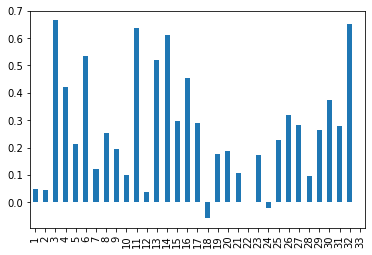

In [16]:
corpval_df['r'].plot.bar()

In [17]:

colours = {"True": "#273c75", "False": "#44bd32"}
corpval_df['r'].plot(
        kind="bar", color=plotdata['significant'].replace(colours)
).legend(
    [
        Patch(facecolor=colours['True']),
        Patch(facecolor=colours['False'])
    ], ["True", "False"]
)
plt.title("prediction")
plt.xlabel("LME")
plt.ylabel("corr")

NameError: name 'plotdata' is not defined

NameError: name 'Patch' is not defined

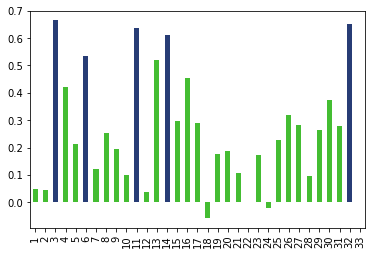

In [18]:

colours = {"True": "#273c75", "False": "#44bd32"}
corpval_df['r'].plot(
        kind="bar", color=corpval_df['significant'].replace(colours)
).legend(
    [
        Patch(facecolor=colours['True']),
        Patch(facecolor=colours['False'])
    ], ["True", "False"]
)
plt.title("prediction")
plt.xlabel("LME")
plt.ylabel("corr")

In [19]:
sns.displot(corpval_df['r'], x="LME", hue="significant")

NameError: name 'sns' is not defined

In [20]:
miport seaborn as sns
sns.displot(corpval_df['r'], x="LME", hue="significant")

SyntaxError: invalid syntax (<ipython-input-20-16392f504221>, line 1)

In [21]:
import seaborn as sns
sns.displot(corpval_df['r'], x="LME", hue="significant")

ValueError: Could not interpret value `LME` for parameter `x`

In [22]:
lme = np.arange(1,34)

In [23]:
import seaborn as sns
sns.displot(corpval_df['r'], x=lme, hue="significant")

ValueError: Could not interpret value `significant` for parameter `hue`